In [6]:
import spacy
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,LSTM, GRU, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import time
import random

In [7]:
df = pd.read_excel("/kaggle/input/students-anxiety-and-depression-dataset/dataset.xlsx")
df.dropna(subset=['text'], inplace=True)
df.head()

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0


**Preprocessing**

In [8]:
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text):
    if isinstance(text, str): 
        doc = nlp(text.lower()) 
        tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
        return " ".join(tokens)
    return ""

if "text" in df.columns:
    df = df.dropna(subset=["text"]).copy()  # remove NaN 
    df.loc[:, "processed_text"] = df["text"].apply(preprocess_text)
else:
    raise ValueError("The dataset does not contain a 'text' column.")

print(df.head())

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


                                                text  label  \
0                                         oh my gosh    1.0   
1  trouble sleeping, confused mind, restless hear...    1.0   
2  All wrong, back off dear, forward doubt. Stay ...    1.0   
3  I've shifted my focus to something else but I'...    1.0   
4  I'm restless and restless, it's been a month n...    1.0   

                                      processed_text  
0                                            oh gosh  
1    trouble sleep confused mind restless heart tune  
2  wrong dear forward doubt stay restless restles...  
3                                shift focus worried  
4                   restless restless month boy mean  


# Task 1

**Train Word2Vec (CBOW and Skip-gram)/FastText**

In [9]:
tokenized_sentences = [text.split() for text in df["processed_text"]]

w2v_cbow = Word2Vec(sentences=tokenized_sentences, vector_size=50, window=5, min_count=1, sg=0)
w2v_sg = Word2Vec(sentences=tokenized_sentences, vector_size=50, window=5, min_count=1, sg=1)
fasttext_model = FastText(sentences=tokenized_sentences, vector_size=50, window=5, min_count=1)

In [10]:
def check_most_similar(model, word):
    if word in model.wv:
        return model.wv.most_similar(word)
    else:
        return f"'{word}' not in vocabulary."

In [11]:
print("CBOW:", check_most_similar(w2v_cbow, "restless"))
print("Skip-gram:", check_most_similar(w2v_sg, "restless"))
print("FastText:", check_most_similar(fasttext_model, "restless"))

CBOW: [('think', 0.9909240007400513), ('today', 0.9908785820007324), ('sad', 0.99080890417099), ('want', 0.9904683232307434), ('wait', 0.9902742505073547), ('heart', 0.9902488589286804), ('know', 0.9899170398712158), ('buy', 0.9896325469017029), ('turn', 0.9895304441452026), ('feel', 0.989389181137085)]
Skip-gram: [('anxious', 0.9961823225021362), ('heart', 0.995279848575592), ('sad', 0.9949492812156677), ('feel', 0.9948596358299255), ('nervous', 0.9948514699935913), ('know', 0.9947019815444946), ('worried', 0.9943780899047852), ('suddenly', 0.9941849112510681), ('night', 0.9938598275184631), ('sleep', 0.993638277053833)]
FastText: [('restlessness', 0.9999955296516418), ('restlessly', 0.999993085861206), ('countless', 0.9999845027923584), ('rest', 0.9999837875366211), ('content', 0.9999824166297913), ('confusion', 0.9999812841415405), ('ress', 0.9999812245368958), ('consultation', 0.9999809861183167), ('congregation', 0.9999807476997375), ('longing', 0.999980092048645)]


In [12]:
df = df.dropna(subset=["label"])

vectorizer = TfidfVectorizer()#conver text to TF-IDF vectors
X = vectorizer.fit_transform(df["processed_text"])
y = df["label"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [15]:
y_pred = model.predict(X_test)

In [16]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9505021520803444


In [17]:
glove_embeddings = {}
with open("/kaggle/input/glove-6b-100d-txtt/glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

**Extract word vectors for common words**

In [18]:
common_words = list(w2v_cbow.wv.index_to_key)[:10]
w2v_cbow_vectors = np.array([w2v_cbow.wv[word] for word in common_words])
w2v_sg_vectors = np.array([w2v_sg.wv[word] for word in common_words])
fasttext_vectors = np.array([fasttext_model.wv[word] for word in common_words])
glove_vectors = np.array([glove_embeddings[word] for word in common_words if word in glove_embeddings])

**t-SNE**

In [19]:
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
w2v_cbow_tsne = tsne.fit_transform(w2v_cbow_vectors)
w2v_sg_tsne = tsne.fit_transform(w2v_sg_vectors)
fasttext_tsne = tsne.fit_transform(fasttext_vectors)
glove_tsne = tsne.fit_transform(glove_vectors)

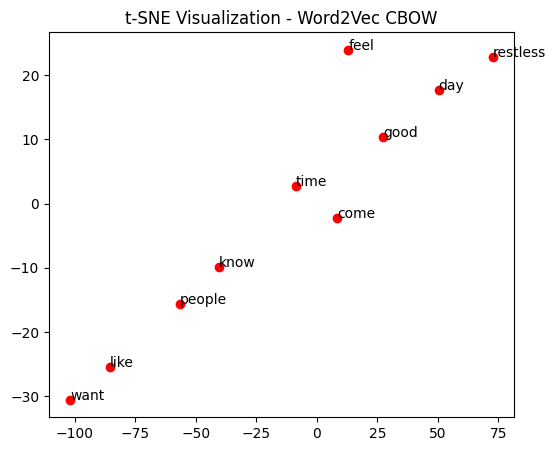

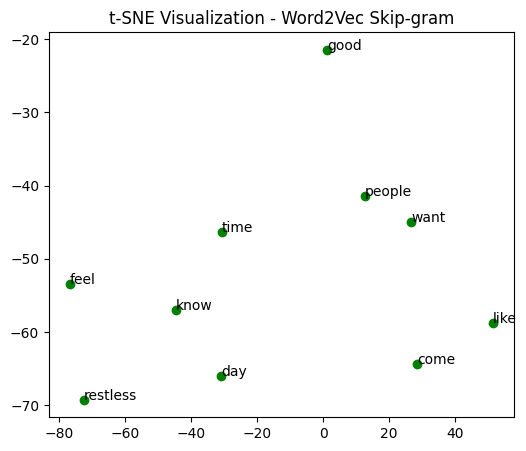

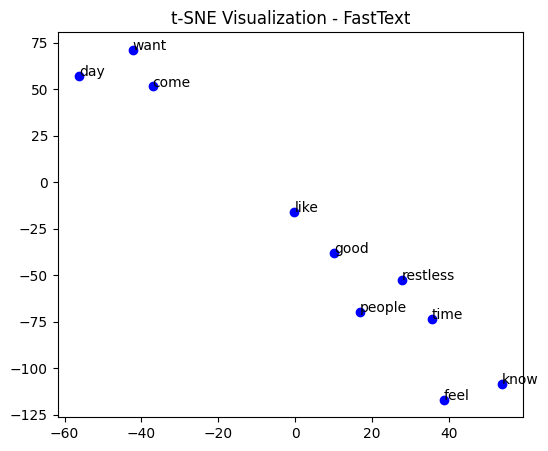

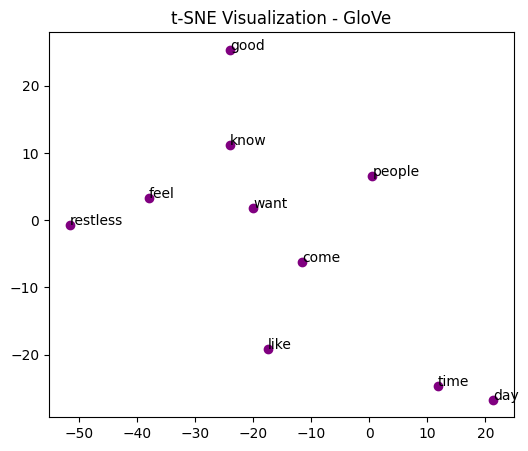

In [20]:
def plot_embeddings(embeddings, words, title, color):
    plt.figure(figsize=(6, 5))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], color=color)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(embeddings[i, 0], embeddings[i, 1]))
    plt.title(title)
    plt.show()
plot_embeddings(w2v_cbow_tsne, common_words, "t-SNE Visualization - Word2Vec CBOW", 'red')
plot_embeddings(w2v_sg_tsne, common_words, "t-SNE Visualization - Word2Vec Skip-gram", 'green')
plot_embeddings(fasttext_tsne, common_words, "t-SNE Visualization - FastText", 'blue')
plot_embeddings(glove_tsne, common_words[:len(glove_tsne)], "t-SNE Visualization - GloVe", 'purple')

In [21]:
word1, word2 = "text", "learning"
cosine_similarities = {
    "Word2Vec CBOW": 1 - cosine(w2v_cbow.wv[word1], w2v_cbow.wv[word2]),
    "Word2Vec Skip-gram": 1 - cosine(w2v_sg.wv[word1], w2v_sg.wv[word2]),
    "FastText": 1 - cosine(fasttext_model.wv[word1], fasttext_model.wv[word2]),
    "GloVe": 1 - cosine(glove_embeddings[word1], glove_embeddings[word2]) if word1 in glove_embeddings and word2 in glove_embeddings else None
}
cosine_df = pd.DataFrame(list(cosine_similarities.items()), columns=["Model", "Cosine Similarity"])
display(cosine_df)

,Model,Cosine Similarity
0,Word2Vec CBOW,0.265306
1,Word2Vec Skip-gram,0.937650
2,FastText,0.999531
3,GloVe,0.418133


# Task2 - RNN for Sentiment Analysis

In [49]:
MAX_VOCAB_SIZE = 5000
MAX_SEQUENCE_LENGTH = 100

**Tokenization & Padding**

In [23]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["processed_text"])
sequences = tokenizer.texts_to_sequences(df["processed_text"])
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post", truncating="post")
y = df["label"].values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Build RNN Model**

In [25]:
rnn_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    SimpleRNN(64, return_sequences=False),
    Dense(1, activation="sigmoid")
])

rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [26]:
print("Training RNN model...")
history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)

Training RNN model...
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.8233 - loss: 0.3980 - val_accuracy: 0.8859 - val_loss: 0.3563
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9008 - loss: 0.3245 - val_accuracy: 0.8859 - val_loss: 0.3550
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8942 - loss: 0.3382 - val_accuracy: 0.8859 - val_loss: 0.3549
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9060 - loss: 0.3133 - val_accuracy: 0.8859 - val_loss: 0.3565
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8908 - loss: 0.3459 - val_accuracy: 0.8859 - val_loss: 0.3561
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8977 - loss: 0.3306 - val_accuracy: 0.8859 - val_loss: 0.3577
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9012 - loss: 0.3229 - val_accuracy: 0.8859 - val_loss: 0.3556
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8987 - loss: 0.3290 - va

**Plot Accuracy & Loss Curves**

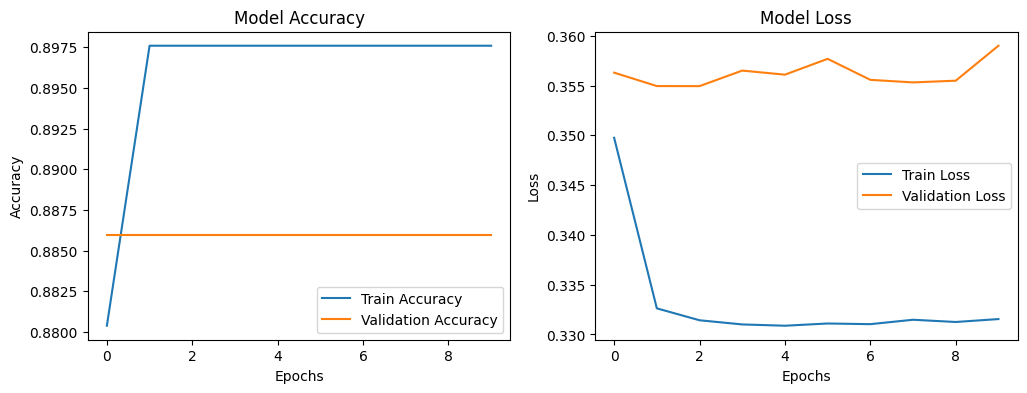

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

**Vanishing Gradient Demonstration**

In [28]:
print("Analyzing vanishing gradient problem...")

def get_gradients(rnn_model, X_sample, y_sample):
    with tf.GradientTape() as tape:
        inputs = tf.convert_to_tensor(X_sample, dtype=tf.float32)
        tape.watch(inputs)
        predictions = rnn_model(inputs, training=True)
        loss = tf.keras.losses.binary_crossentropy(tf.reshape(y_sample, (-1, 1)), predictions)  # Fix here

    grads = tape.gradient(loss, rnn_model.trainable_variables)
    return grads

Analyzing vanishing gradient problem...


**Compute gradients**

In [29]:
X_sample, y_sample = X_train[:1], y_train[:1]
gradients = get_gradients(rnn_model, X_sample, y_sample)

**Plot gradients**

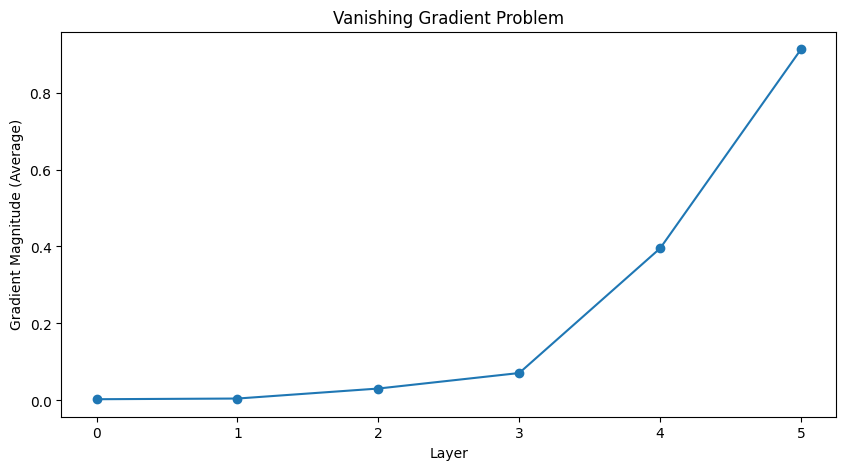

In [30]:
plt.figure(figsize=(10, 5))
plt.plot([np.mean(np.abs(grad.values.numpy())) if isinstance(grad, tf.IndexedSlices)
          else np.mean(np.abs(grad.numpy())) for grad in gradients], marker="o")
plt.title("Vanishing Gradient Problem")
plt.xlabel("Layer")
plt.ylabel("Gradient Magnitude (Average)")
plt.show()

# Task 3 - LSTM and GRU Comparison

In [31]:
print("Training LSTM model...")

lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    LSTM(64, return_sequences=False),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"])

start_time = time.time()
history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
lstm_time = time.time() - start_time

Training LSTM model...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8914 - loss: 0.3844 - val_accuracy: 0.8859 - val_loss: 0.3566
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8976 - loss: 0.3313 - val_accuracy: 0.8859 - val_loss: 0.3573
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8983 - loss: 0.3297 - val_accuracy: 0.8859 - val_loss: 0.3552
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8975 - loss: 0.3316 - val_accuracy: 0.8859 - val_loss: 0.3563
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8963 - loss: 0.3339 - val_accuracy: 0.8859 - val_loss: 0.3555
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9068 - loss: 0.3104 - val_accuracy: 0.8859 - val_loss: 0.3558
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8972 - loss: 0.3322 - val_accuracy: 0.8859 - val_loss: 0.3550
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8964 - loss: 0.

In [32]:
print("Training GRU model...")

gru_model = Sequential([
     Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    GRU(64, return_sequences=False),
    Dense(1, activation="sigmoid")
])

gru_model.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"])

start_time = time.time()
history_gru = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)
gru_time = time.time() - start_time

Training GRU model...
Epoch 1/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8657 - loss: 0.3984 - val_accuracy: 0.8859 - val_loss: 0.3550
Epoch 2/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8969 - loss: 0.3329 - val_accuracy: 0.8859 - val_loss: 0.3567
Epoch 3/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8956 - loss: 0.3363 - val_accuracy: 0.8859 - val_loss: 0.3556
Epoch 4/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8998 - loss: 0.3261 - val_accuracy: 0.8859 - val_loss: 0.3550
Epoch 5/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8960 - loss: 0.3349 - val_accuracy: 0.8859 - val_loss: 0.3573
Epoch 6/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8987 - loss: 0.3295 - val_accuracy: 0.8859 - val_loss: 0.3554
Epoch 7/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9002 - loss: 0.3264 - val_accuracy: 0.8859 - val_loss: 0.3551
Epoch 8/10
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8970 - loss: 0.3

# LSTM vs GRU Comparison: Training Accuracy & Loss

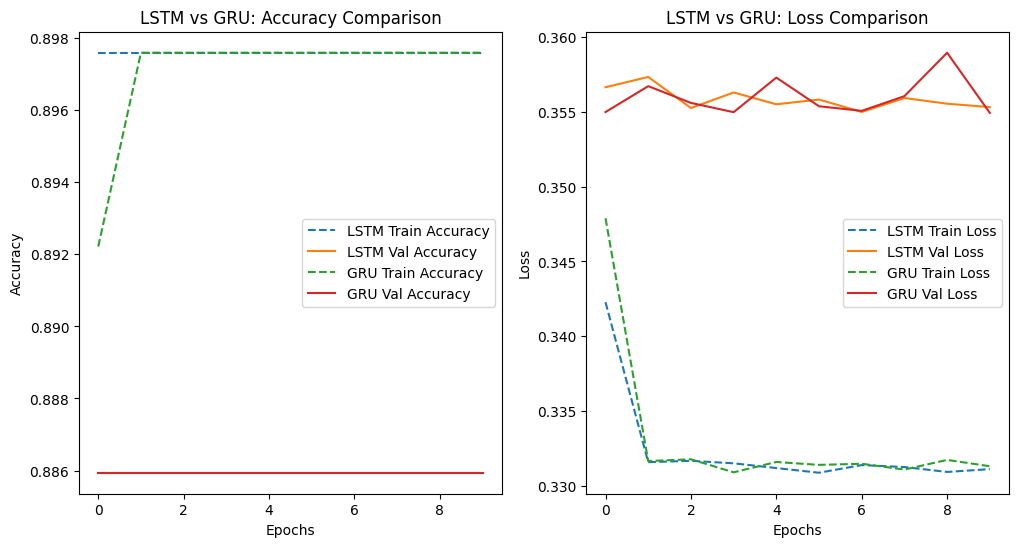

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1) # accuracy comparison
plt.plot(history_lstm.history["accuracy"], label="LSTM Train Accuracy", linestyle="--")
plt.plot(history_lstm.history["val_accuracy"], label="LSTM Val Accuracy", linestyle="-")
plt.plot(history_gru.history["accuracy"], label="GRU Train Accuracy", linestyle="--")
plt.plot(history_gru.history["val_accuracy"], label="GRU Val Accuracy", linestyle="-")
plt.title("LSTM vs GRU: Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


plt.subplot(1, 2, 2)# loss comparis
plt.plot(history_lstm.history["loss"], label="LSTM Train Loss", linestyle="--")
plt.plot(history_lstm.history["val_loss"], label="LSTM Val Loss", linestyle="-")
plt.plot(history_gru.history["loss"], label="GRU Train Loss", linestyle="--")
plt.plot(history_gru.history["val_loss"], label="GRU Val Loss", linestyle="-")
plt.title("LSTM vs GRU: Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

**Performance Report**

In [34]:
performance_report = pd.DataFrame({
    "Model": ["LSTM", "GRU"],
    "Training Time (seconds)": [ lstm_time, gru_time],
    "Final Train Accuracy": [
        history_lstm.history["accuracy"][-1],
        history_gru.history["accuracy"][-1]
    ],
    "Final Val Accuracy": [
        history_lstm.history["val_accuracy"][-1],
        history_gru.history["val_accuracy"][-1]
    ],
    "Final Train Loss": [
        history_lstm.history["loss"][-1],
        history_gru.history["loss"][-1]
    ],
    "Final Val Loss": [
        history_lstm.history["val_loss"][-1],
        history_gru.history["val_loss"][-1]
    ]
})

print("\nPerformance Report:\n", performance_report)


Performance Report:
   Model  Training Time (seconds)  Final Train Accuracy  Final Val Accuracy  \
0  LSTM                14.913969              0.897597             0.88594   
1   GRU                13.662933              0.897597             0.88594   

   Final Train Loss  Final Val Loss  
0          0.331119        0.355309  
1          0.331313        0.354921  


# Task 4 - LSTM text generation

In [37]:
#text_data = df['text'].astype(str).tolist()
df['processed_text'] = df['text'].apply(preprocess_text)
sentences = df['processed_text'].tolist()

In [38]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

In [39]:
input_sequences = []
for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

**Padding sequences**

In [40]:
X = pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')
y = np.array([seq[-1] for seq in input_sequences])
y = tf.keras.utils.to_categorical(y, num_classes=total_words)

In [41]:
lstm_model = Sequential([
    Embedding(total_words, 128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(total_words, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the LSTM model
start_time = time.time()
lstm_model.fit(X, y, epochs=20, batch_size=32, verbose=1)
lstm_training_time = time.time() - start_time


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.0143 - loss: 7.7496
Epoch 2/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.0343 - loss: 6.4713
Epoch 3/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.0424 - loss: 6.0827
Epoch 4/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.0477 - loss: 5.8221
Epoch 5/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.0585 - loss: 5.6280
Epoch 6/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.0613 - loss: 5.5093
Epoch 7/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.0751 - loss: 5.3136
Epoch 8/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.0910 - loss: 5.1065
Epoch 9/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.1194 - loss: 4.8677
Epoch 10/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.1492 - loss: 4.6599
Epoch 11/20
1061/1061 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.1868 - loss: 4.4787
Epoch 12

In [44]:
def generate_text_lstm(model, seed_text, next_words=20, temperature=0.8, top_p=0.9):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH-1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]
        
        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        probabilities = exp_preds / np.sum(exp_preds)

        sorted_indices = np.argsort(probabilities)[::-1]
        cumulative_probs = np.cumsum(probabilities[sorted_indices])
        
        top_p_indices = sorted_indices[cumulative_probs <= top_p]
        if len(top_p_indices) == 0:
            top_p_indices = sorted_indices[:5] 
        
        predicted_index = np.random.choice(top_p_indices)
        output_word = tokenizer.index_word.get(predicted_index, "")

        if output_word:
            seed_text += " " + output_word
        else:
            break

    return seed_text

**Test LSTM text generation**

In [45]:
print("\nGenerated with LSTM:", generate_text_lstm(lstm_model, "I feel anxious", next_words=20, temperature=0.8, top_p=0.9))


Generated with LSTM: I feel anxious tired sad year year month get later open oh tell miss tell tell miss watch tell tell oh tell oh


In [51]:
# ------------------------------------------------------------
# ✅ **Using GloVe 100D Embeddings for Better Learning**
# ------------------------------------------------------------
# Load GloVe embeddings
embedding_index = {}
with open("/kaggle/input/glove-6b-100d-txtt/glove.6B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coef

# Prepare embedding matrix
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((total_words, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < total_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [52]:
# ------------------------------------------------------------
# ✅ **Improved Bi-LSTM Model**
# ------------------------------------------------------------
bi_lstm_model = Sequential([
    Embedding(total_words, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),  # 🔹 Add normalization to stabilize training
    Dropout(0.3),
    LSTM(128),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(total_words, activation='softmax')
])

bi_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0003), metrics=['accuracy'])

# 🔹 Train the Bi-LSTM model
start_time = time.time()
bi_lstm_model.fit(X, y, epochs=10, batch_size=64, verbose=1)  # 🔹 Increase epochs for better accuracy
bi_lstm_training_time = time.time() - start_time

Epoch 1/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - accuracy: 0.0660 - loss: 7.7350
Epoch 2/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.4806 - loss: 4.1560
Epoch 3/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6611 - loss: 2.7415
Epoch 4/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7396 - loss: 1.9972
Epoch 5/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7899 - loss: 1.5076
Epoch 6/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8266 - loss: 1.1416
Epoch 7/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8667 - loss: 0.8134
Epoch 8/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9034 - loss: 0.5290
Epoch 9/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9275 - loss: 0.3518
Epoch 10/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9465 - loss: 0.2331
Epoch 11/40
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9571 - loss: 0.1854
Epoch 12/40
531/531 ━━━━━━━━━━

In [53]:
# ------------------------------------------------------------
# ✅ **Improved Text Generation Function (Fixed Sampling)**
# ------------------------------------------------------------
def generate_text_bilstm(model, seed_text, next_words=20, temperature=0.7, top_p=0.9):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH-1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]
        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        probabilities = exp_preds / np.sum(exp_preds)

        sorted_indices = np.argsort(probabilities)[::-1]
        cumulative_probs = np.cumsum(probabilities[sorted_indices])
        top_p_indices = sorted_indices[cumulative_probs <= top_p]
        if len(top_p_indices) == 0:
            top_p_indices = sorted_indices[:5]

        predicted_index = np.random.choice(top_p_indices)
        output_word = tokenizer.index_word.get(predicted_index, "")

        if output_word:
            seed_text += " " + output_word
        else:
            break

    return seed_text

# 🔹 Test Improved Bi-LSTM Text Generation
print("\nGenerated with Fixed Bi-LSTM:", generate_text_bilstm(bi_lstm_model, "My biggest fear is", next_words=20, temperature=0.7, top_p=0.9))

# ------------------------------------------------------------
# ✅ **Performance Comparison**
# ------------------------------------------------------------
performance_report = pd.DataFrame({
    "Model": ["Improved Bi-LSTM"],
    "Training Time (seconds)": [bi_lstm_training_time]
})

print("\nPerformance Report:\n", performance_report)



Generated with Fixed Bi-LSTM: My biggest fear is tbtb dreamzen fanart lopyu smstann uwu rtan yakari gabole henpokorino oiii chimolaaaaaaaaa jaehyun angelðÿ pnapasayaw acawo blasian muntikan lupical cago

Performance Report:
               Model  Training Time (seconds)
0  Improved Bi-LSTM               482.015881


# Task 5 - Bidirectional LSTM Model

In [46]:
bi_lstm_model = Sequential([
    Embedding(total_words, 128, input_length=MAX_SEQUENCE_LENGTH),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(128),
    Dense(128, activation='relu'),
    Dense(total_words, activation='softmax')
])

bi_lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# 🔹 Train the Bi-LSTM model
start_time = time.time()
bi_lstm_model.fit(X, y, epochs=30, batch_size=64, verbose=1)
bi_lstm_training_time = time.time() - start_time


Epoch 1/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.0142 - loss: 8.0010
Epoch 2/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0270 - loss: 6.3809
Epoch 3/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.0372 - loss: 5.9785
Epoch 4/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0428 - loss: 5.7047
Epoch 5/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0429 - loss: 5.5449
Epoch 6/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0485 - loss: 5.3937
Epoch 7/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0510 - loss: 5.2883
Epoch 8/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0520 - loss: 5.1596
Epoch 9/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0570 - loss: 5.0168
Epoch 10/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0610 - loss: 4.9121
Epoch 11/20
531/531 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.0625 - loss: 4.8279
Epoch 12/20
531/531 ━━━━━━━━━━

In [47]:
def generate_text_bilstm(model, seed_text, next_words=20, temperature=0.7, top_p=0.9):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH-1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]
        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        probabilities = exp_preds / np.sum(exp_preds)

        sorted_indices = np.argsort(probabilities)[::-1]
        cumulative_probs = np.cumsum(probabilities[sorted_indices])
        top_p_indices = sorted_indices[cumulative_probs <= top_p]
        if len(top_p_indices) == 0:
            top_p_indices = sorted_indices[:5]

        predicted_index = np.random.choice(top_p_indices)
        output_word = tokenizer.index_word.get(predicted_index, "")

        if output_word:
            seed_text += " " + output_word
        else:
            break

    return seed_text

**test Bi-LSTM text generation**

In [48]:
print("\nGenerated with Bi-LSTM:", generate_text_bilstm(bi_lstm_model, "My biggest fear is", next_words=20, temperature=0.7, top_p=0.9))


Generated with Bi-LSTM: My biggest fear is garo ley fitness aishsjansjkssn iiiihhhhh belake childhoodmemorie yfakerni appointment inhabitant mercure dena legally wicke total prophet vihari matunda dirmh madepmantebmanetep


**ffff**

In [ ]:
print("Preprocessing text for text generation...")

# Tokenization
MAX_VOCAB_SIZE = 10000  # Adjust vocabulary size based on dataset
MAX_SEQUENCE_LENGTH = 50  # Max sequence length for training

# Assuming `df['processed_text']` contains the cleaned student anxiety dataset
sentences = df['processed_text'].tolist()

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
total_words = len(tokenizer.word_index) + 1

In [ ]:
# Convert text to sequences
input_sequences = []
for line in sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


In [ ]:

# Padding sequences
X = pad_sequences(input_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre')

y = np.array([seq[-1] for seq in input_sequences])

print(f"Dataset Prepared for Text Generation: X shape: {X.shape}, y shape: {y.shape}")


In [ ]:
lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(total_words, activation='softmax') 
])

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

lstm_model.fit(X, y, epochs=20, batch_size=32, verbose=1)

In [ ]:
# ------------------------------
# Generate Text
# ------------------------------
def generate_text(model, seed_text, next_words=20, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQUENCE_LENGTH-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]
        predictions = np.asarray(predictions).astype('float64')
        predictions = np.log(predictions + 1e-10) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)
        predicted_index = np.random.choice(len(predictions), p=predictions)
        output_word = tokenizer.index_word.get(predicted_index, "")
        seed_text += " " + output_word
    return seed_text


In [ ]:

# Generate text samples with different seeds
seed_sentences = ["I feel anxious", "I am struggling with", "My biggest fear is"]
for seed in seed_sentences:
    print(f"\nGenerated with seed '{seed}':", generate_text(lstm_model, seed, next_words=20, temperature=0.8))


In [ ]:
print("Training Bidirectional LSTM model...")

bi_lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128),
    Bidirectional(LSTM(128, return_sequences=True)),  # Bi-LSTM layer
    Dropout(0.3),
    LSTM(128),  # Another LSTM layer
    Dense(128, activation='relu'),
    Dense(1, activation="sigmoid")  # Binary classification (anxiety presence)
])

# Compile the model
bi_lstm_model.compile(optimizer=Adam(learning_rate=0.0005), loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
start_time = time.time()
history_bi_lstm = bi_lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)
bi_lstm_time = time.time() - start_time

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def generate_text_bilstm(model, tokenizer, seed_text, next_words=20, max_sequence_length=MAX_SEQUENCE_LENGTH, temperature=1.0):
    """
    Generate text using a trained Bidirectional LSTM model.

    Parameters:
        model: Trained Bi-LSTM model.
        tokenizer: Tokenizer used during training.
        seed_text: The starting text.
        next_words: Number of words to generate.
        max_sequence_length: Sequence length for padding.
        temperature: Controls randomness (higher = more random output).

    Returns:
        Generated text.
    """
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length, padding='pre')

        # Predict the probabilities of the next word
        predictions = model.predict(token_list, verbose=0)
        predictions = predictions.astype("float64") 

        # Apply temperature scaling
        predictions = np.log(predictions + 1e-8) / temperature
        exp_preds = np.exp(predictions)
        probabilities = exp_preds / np.sum(exp_preds)

        # Sample from the distribution
        predicted_index = np.random.choice(len(probabilities[0]), p=probabilities[0])
        
        # Convert index to word
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_index:
                output_word = word
                break
        
        if output_word:
            seed_text += " " + output_word
        else:
            break  # Stop if no valid word is found

    return seed_text


In [ ]:
# Generate text using the fixed Bi-LSTM generator
seed_texts = [
    "I feel anxious",
    "I am struggling with",
    "My biggest fear is"
]

for seed in seed_texts:
    generated_text = generate_text_bilstm(bi_lstm_model, tokenizer, seed_text=seed, next_words=10, temperature=0.5)
    print(f"Generated with seed '{seed}':\n{generated_text}\n")


In [ ]:
# -------------------------------------
# Performance Comparison
# -------------------------------------
import pandas as pd

# Collect performance data
performance_report = pd.DataFrame({
    "Model": ["LSTM", "Bidirectional LSTM"],
    "Training Time (seconds)": [lstm_time, bi_lstm_time],
    "Final Train Accuracy": [
        history_lstm.history["accuracy"][-1],
        history_bi_lstm.history["accuracy"][-1]
    ],
    "Final Val Accuracy": [
        history_lstm.history["val_accuracy"][-1],
        history_bi_lstm.history["val_accuracy"][-1]
    ],
    "Final Train Loss": [
        history_lstm.history["loss"][-1],
        history_bi_lstm.history["loss"][-1]
    ],
    "Final Val Loss": [
        history_lstm.history["val_loss"][-1],
        history_bi_lstm.history["val_loss"][-1]
    ]
})

print("\nPerformance Report:\n", performance_report)


In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy Comparison
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history["accuracy"], label="LSTM Train Accuracy", linestyle="--")
plt.plot(history_lstm.history["val_accuracy"], label="LSTM Val Accuracy")
plt.plot(history_bi_lstm.history["accuracy"], label="Bidirectional LSTM Train Accuracy", linestyle="--")
plt.plot(history_bi_lstm.history["val_accuracy"], label="Bidirectional LSTM Val Accuracy")
plt.title("LSTM vs. Bi-LSTM: Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history["loss"], label="LSTM Train Loss", linestyle="--")
plt.plot(history_lstm.history["val_loss"], label="LSTM Val Loss")
plt.plot(history_bi_lstm.history["loss"], label="Bidirectional LSTM Train Loss", linestyle="--")
plt.plot(history_bi_lstm.history["val_loss"], label="Bidirectional LSTM Val Loss")
plt.title("LSTM vs. Bi-LSTM: Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [ ]:
# 5. Text Generation with LSTM
X_gen, y_gen = input_sequences[:,:-1], input_sequences[:,-1] #input_sequences is now a numpy array.
y_gen = tf.keras.utils.to_categorical(y_gen, num_classes=total_words)

gen_model = Sequential([
    Embedding(total_words, 100),
    LSTM(150),
    Dense(total_words, activation='softmax')
])
gen_model.compile(loss='categorical_crossentropy', optimizer='adam')
gen_model.fit(X_gen, y_gen, epochs=20, verbose=1)



In [ ]:
def generate_text(seed_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

print("\nGenerated Text (Seed: 'I feel')")
print(generate_text("I feel", 20, gen_model, max_sequence_len))
print("\nGenerated Text (Seed: 'My anxiety')")
print(generate_text("My anxiety", 20, gen_model, max_sequence_len))


In [ ]:

# 6. Bidirectional LSTM
bidirectional_lstm_model = Sequential([
    Embedding(total_words, 100),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')
])
bidirectional_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bidirectional_lstm_history = bidirectional_lstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

print("\nBidirectional LSTM Validation Accuracy:", bidirectional_lstm_history.history['val_accuracy'][-1])